In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hf452g7o because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Constants, maps, etc.
PHENOMENA = {
    "HV": "Humour", 
    "IV": "Irony",
    "ISV": "IndirectSpeech",
    "DV": "Deceits",
    "CIV": "CoherenceInference",
    "MV": "Maxims",
    "MPV": "Metaphor"
}
PHENOMENA_PRETTY = {
    "HV": "Humor", 
    "IV": "Irony",
    "ISV": "IndirectSpeech",
    "DV": "Deceits",
    "CIV": "Coherence",
    "MV": "Maxims",
    "MPV": "Metaphor"
}
CHANCE = {
    "Humor": 1/5,
    "Irony": 1/4,
    "IndirectSpeech": 1/4,
    "Deceits": 1/4,
    "Coherence": 1/2,
    "Maxims": 1/4,
    "Metaphor": 1/5
}
# Models and "pretty" names
MODELS = {
    "gpt2": "GPT-2",
    "tk-instruct-3b-def-pos": "Tk-Instruct (3B)",
    "tk-instruct-11b-def-pos": "Tk-Instruct (11B)",
    "flan-t5-base": "Flan-T5 (base)",
    "flan-t5-xl": "Flan-T5 (XL)",
    "text-ada-001": "InstructGPT-3 (ada)",
    "text-davinci-002": "text-davinci-002",
    "human": "Human"
}
MODEL_ORDER = [
    "GPT-2", 
    "Tk-Instruct (3B)", 
    "Tk-Instruct (11B)",
    "Flan-T5 (base)", 
    "Flan-T5 (XL)", 
    "InstructGPT-3 (ada)", 
    "text-davinci-002", 
    "Human"
] # sorted(MODELS.values()) 
ARTIFICIAL_MODELS = [m for m in MODEL_ORDER if m != "Human"]
SEEDS = range(5)

# Styling for visualizations
sns.set(style="white", font="Liberation Sans", font_scale=1.5)
paired = sns.color_palette("Paired")
PAL = {
    "Human": paired[11], #"lightgrey",
    "InstructGPT-3 (ada)": paired[0],
    "text-davinci-002": paired[1],
    "Flan-T5 (base)": paired[6],
    "Flan-T5 (XL)": paired[7],
    "Tk-Instruct (3B)": paired[2],
    "Tk-Instruct (11B)": paired[3],
    "GPT-2": paired[4],
}
ERR_STYLE = dict(errwidth=1, capsize=0.03)
CHANCE_STYLE = dict(color="k", ls="--", alpha=0.7, lw=2)

def render(outpath):
    plt.savefig(f"./figures/{outpath}", bbox_inches="tight", dpi=300)
    print(f"Rendered figure to {outpath}")

# Read model data

In [3]:
from collections import defaultdict
def read_model_data(RESULT_DIR="../model_results"):
    all_dfs = defaultdict(list)
    
    # Read CSV files.
    for phen in tqdm(PHENOMENA.values()):
        for model in MODELS.keys():
            if model != "human":
                for seed in SEEDS:
                    # Main results
                    f = f"{RESULT_DIR}/{phen}_{model}_seed{seed}_examples0.csv"
                    try:
                        df = pd.read_csv(f)
                        all_dfs["main"].append(df)
                    except:
                        continue
                    # No-story modification
                    suffix = "no-story"
                    try:
                        f = f"{RESULT_DIR}/{phen}_{suffix}_{model}_seed{seed}_examples0.csv"
                        df = pd.read_csv(f)
                        all_dfs[suffix].append(df)
                    except:
                        continue
    
    # Combine and tidy up DataFrames.
    for k, dfs in all_dfs.items():
        df = pd.concat(dfs).reset_index().drop("index", axis=1)
        df.phenomenon = df.phenomenon.map(PHENOMENA_PRETTY)
        df.model = df.model.map(MODELS)
        for c in ["original_labels_complex", "randomized_labels_complex"]:
            df[c] = df[c].apply(eval)
        
        all_dfs[k] = df
    return all_dfs

In [4]:
model_dfs = read_model_data()
model_dfs["main"].head()

  0%|          | 0/7 [00:00<?, ?it/s]

,phenomenon,item_id,content,randomized_option_order,randomized_labels_complex,randomized_true_answer,original_labels_complex,is_example,prompt,seed,generation,generation_isvalid,distribution,prob_true_answer,answer,correct,answer_label_complex,model,randomized_violated_maxims,original_violated_maxims
0,Humor,1,A woman is taking a shower. All of a sudden th...,"[3, 5, 4, 1, 2]","[AssociativeNonSequitur, FunnyNonSequitur, Neu...",4,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0,1,True,"{'1': 0.6884523736145644, '2': 0.0737050370110...",0.058305,1,False,AssociativeNonSequitur,GPT-2,NaN,NaN
1,Humor,2,The neighborhood borrower approached Mr. Smith...,"[5, 2, 3, 1, 4]","[FunnyNonSequitur, IncorrectStraightforward, A...",4,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0,1,True,"{'1': 0.584949447941457, '2': 0.07207991468779...",0.061653,1,False,FunnyNonSequitur,GPT-2,NaN,NaN
2,Humor,3,A worried patient tells the doctor that he is ...,"[1, 3, 4, 5, 2]","[CorrectNonLiteral, AssociativeNonSequitur, Ne...",1,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0,1,True,"{'1': 0.6523633761718879, '2': 0.0535492468353...",0.652363,1,True,CorrectNonLiteral,GPT-2,NaN,NaN
3,Humor,4,Martha walked into a pastry shop. After survey...,"[4, 3, 1, 2, 5]","[NeutralNonSequitur, AssociativeNonSequitur, C...",3,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0,1,True,"{'1': 0.6635112457839994, '2': 0.0912105712154...",0.116205,1,False,NeutralNonSequitur,GPT-2,NaN,NaN
4,Humor,5,"A man went to an eye doctor and asked, ""Doctor...","[5, 3, 2, 4, 1]","[FunnyNonSequitur, AssociativeNonSequitur, Inc...",5,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0,1,True,"{'1': 0.6323253469142168, '2': 0.0606824209757...",0.075520,1,False,FunnyNonSequitur,GPT-2,NaN,NaN


# Fix complex coding for Deceits, Irony, Metaphor

In [6]:
def update_complex_labels(row):
    # Read complex answer key.
    phen = row.phenomenon
    if phen in ["Deceits", "Irony", "Metaphor", "Maxims"]:
        cols = [1,2,6] if phen == "Metaphor" else [1,2,3]
        key = pd.read_csv(
            f"../fj_raw_data/{phen}KeyComplex.txt",
            sep="\t", 
            names=["item_id", "option_id", "label_complex"],
            usecols=cols # skip the phenomenon column
        ).sort_values(by=["item_id", "option_id"]).set_index(["item_id", "option_id"])

        # Update labels.
        try:
            original_labels = key.loc[row.item_id].label_complex.tolist()
        except:
            print(phen, row.item_id)
            print(key.head())
            print(key.index)
            raise
        row.original_labels_complex = original_labels
        random_inds = eval(row.randomized_option_order)
        randomized_labels = [original_labels[ind-1] for ind in random_inds]
        row.randomized_labels_complex = randomized_labels
        answer_label = randomized_labels[row.answer-1]
        row.answer_label_complex = answer_label
        return row
    else:
        return row

for k, df in tqdm(model_dfs.items()):
    model_dfs[k] = df.apply(update_complex_labels, axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

# Read human data

In [7]:
def read_human_data():
    dfs = []
    for phen in PHENOMENA.values():
        df = pd.read_csv(f"../human_data/fj/Human_{phen}.csv")
        if phen == "CoherenceInference":
            df["OptionChosen"] = df.OptionChosen.map({"Coherent": "Answer1", "Incoherent": "Answer2"})
        dfs.append(df)
    df = pd.concat(dfs).drop("Unnamed: 0", axis=1).reset_index().drop("index", axis=1)
    df = df.rename(columns={"itemNum": "item_id", "Correct": "correct", "Task": "phenomenon", "OptionChosen": "answer"})
    df.answer = df.answer.apply(lambda x: int(x[-1]))
    df.phenomenon = df.phenomenon.map(PHENOMENA_PRETTY)
    df["model"] = "Human"
    return df

human_df = read_human_data()
print("Number of human participants:", human_df.pKey.nunique())

Number of human participants: 374


In [8]:
# Add complex answer labels, based on the model data.
model_df = model_dfs["main"]

complex_value_labels = {
    phen: {
        item_id: model_df[(model_df.phenomenon==phen)&(model_df.item_id==item_id)].original_labels_complex.values[0]
        for item_id in model_df[(model_df.phenomenon==phen)].item_id.unique()
    }
    for phen in model_df.phenomenon.unique()
}

for i, row in tqdm(human_df.iterrows(), total=len(human_df.index)):
    d = complex_value_labels[row.phenomenon]
    if row.item_id in d.keys():
        complex_labels = d[row.item_id]
        answer_label = complex_labels[int(row.answer)-1]
        human_df.loc[i, "answer_label_complex"] = answer_label
        
human_df.head()

  0%|          | 0/63580 [00:00<?, ?it/s]

,pKey,item_id,correct,phenomenon,answer,model,answer_label_complex
0,100,2,1,Humor,1,Human,CorrectNonLiteral
1,100,10,0,Humor,2,Human,IncorrectStraightforward
2,100,25,1,Humor,1,Human,CorrectNonLiteral
3,100,14,1,Humor,1,Human,CorrectNonLiteral
4,100,11,1,Humor,1,Human,CorrectNonLiteral


# Combine model and human data

In [9]:
main_df = pd.concat([model_df, human_df])
main_df.head()

,phenomenon,item_id,content,randomized_option_order,randomized_labels_complex,randomized_true_answer,original_labels_complex,is_example,prompt,seed,...,generation_isvalid,distribution,prob_true_answer,answer,correct,answer_label_complex,model,randomized_violated_maxims,original_violated_maxims,pKey
0,Humor,1,A woman is taking a shower. All of a sudden th...,"[3, 5, 4, 1, 2]","[AssociativeNonSequitur, FunnyNonSequitur, Neu...",4.0,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0.0,...,True,"{'1': 0.6884523736145644, '2': 0.0737050370110...",0.058305,1,0,AssociativeNonSequitur,GPT-2,NaN,NaN,NaN
1,Humor,2,The neighborhood borrower approached Mr. Smith...,"[5, 2, 3, 1, 4]","[FunnyNonSequitur, IncorrectStraightforward, A...",4.0,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0.0,...,True,"{'1': 0.584949447941457, '2': 0.07207991468779...",0.061653,1,0,FunnyNonSequitur,GPT-2,NaN,NaN,NaN
2,Humor,3,A worried patient tells the doctor that he is ...,"[1, 3, 4, 5, 2]","[CorrectNonLiteral, AssociativeNonSequitur, Ne...",1.0,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0.0,...,True,"{'1': 0.6523633761718879, '2': 0.0535492468353...",0.652363,1,1,CorrectNonLiteral,GPT-2,NaN,NaN,NaN
3,Humor,4,Martha walked into a pastry shop. After survey...,"[4, 3, 1, 2, 5]","[NeutralNonSequitur, AssociativeNonSequitur, C...",3.0,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0.0,...,True,"{'1': 0.6635112457839994, '2': 0.0912105712154...",0.116205,1,0,NeutralNonSequitur,GPT-2,NaN,NaN,NaN
4,Humor,5,"A man went to an eye doctor and asked, ""Doctor...","[5, 3, 2, 4, 1]","[FunnyNonSequitur, AssociativeNonSequitur, Inc...",5.0,"[CorrectNonLiteral, IncorrectStraightforward, ...",False,Task: You will read jokes that are missing the...,0.0,...,True,"{'1': 0.6323253469142168, '2': 0.0606824209757...",0.075520,1,0,FunnyNonSequitur,GPT-2,NaN,NaN,NaN


# Accuracy

Rendered figure to accuracy.pdf


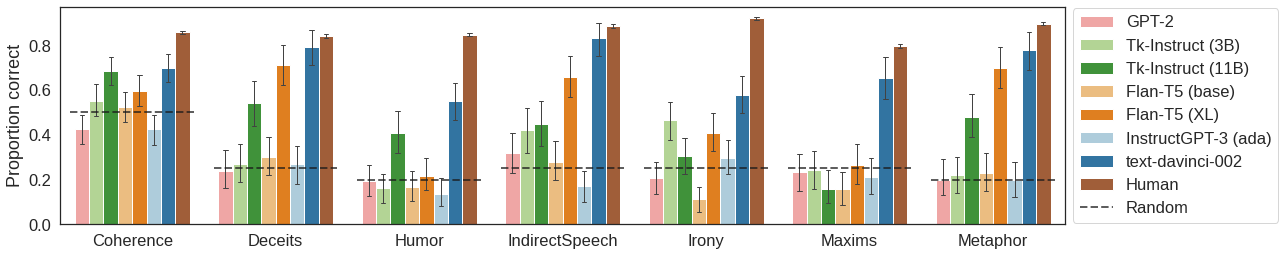

In [10]:
import matplotlib.lines as mlines

def plot_accuracy(df):
    PHEN_ORDER = sorted(df.phenomenon.unique())
    ax = sns.barplot(
        data=df, x="phenomenon", y="correct", 
        order=PHEN_ORDER, hue="model", hue_order=MODEL_ORDER, palette=PAL, 
        **ERR_STYLE
    )
    ax.set_xlabel("")
    ax.set_ylabel("Proportion correct")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
    labels.append("Random")
    ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gcf().set_size_inches(18,4)
    
    n_phen = len(PHEN_ORDER)
    for i, phen in enumerate(PHEN_ORDER):
        # Draw different random baseline for each task
        ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)
    
plot_accuracy(main_df)
render("accuracy.pdf")

                      correct  model_size
model                                    
Flan-T5 (XL)         0.507692      3000.0
Flan-T5 (base)       0.279290       250.0
GPT-2                0.275740       117.0
InstructGPT-3 (ada)  0.263905       350.0
Tk-Instruct (11B)    0.459172     11000.0
Tk-Instruct (3B)     0.357396      3000.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Rendered figure to accuracy_vs_size.pdf


posx and posy should be finite values
posx and posy should be finite values


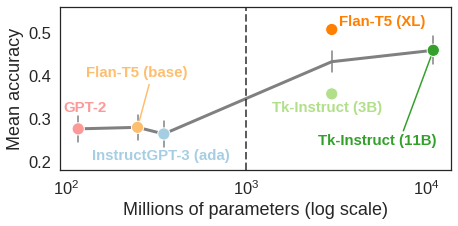

In [11]:
def plot_accuracy_vs_size(df):
    model_sizes = {
        "GPT-2": 117*10e6,
        "Tk-Instruct (3B)": 3*10e9,
        "Tk-Instruct (11B)": 11*10e9,
        "Flan-T5 (base)": 250*10e6,
        "Flan-T5 (XL)": 3*10e9,
        "Flan-T5 (XXL)": 11*10e9,
        "InstructGPT-3 (ada)": 350*10e6
    }
    df["model_size"] = df.model.map(model_sizes) / 10e6
    g = df.groupby(["model"]).correct.mean().to_frame()
    g["model_size"] = g.index.map(model_sizes) / 10e6
    g = g.dropna()
    print(g)
    ax = plt.gca()
    ax = sns.lineplot(
        data=df.reset_index(), 
        x="model_size", y="correct",
        err_style="bars", 
        color="gray",
        lw=3, zorder=-100
    ) #, color="tab:red")
    ax = sns.scatterplot(
        x=g["model_size"], y=g["correct"], 
        ax=ax, 
        s=150, 
        c=[PAL[model] for model in g.index], 
        zorder=100
    )
    label_shifts = {
        "GPT-2": (-20, 0.04),
        "Tk-Instruct (3B)": (-1600, -0.04),
        "Tk-Instruct (11B)": (-8500, -0.22),
        "Flan-T5 (base)": (-120, 0.12),
        "Flan-T5 (XL)": (300, 0.01), #(-2600, 0.01),
        "InstructGPT-3 (ada)": (-210, -0.06)#(100, -0.02)
    }
    for model in df.model.unique():
        n_param, acc = df[df.model==model].model_size.values[0], df[df.model==model].correct.mean()
        # print(model, n_param, acc)
        xshift, yshift = label_shifts[model] if model in label_shifts else (0,0)
        ax.text(n_param+xshift, acc+yshift, model, size="small", color=PAL[model], fontweight="extra bold")
        if model == "Flan-T5 (base)":
            ax.plot([n_param, n_param+40], [acc, acc+yshift-0.02], color=PAL[model])
        elif model == "Tk-Instruct (11B)":
            ax.plot([n_param, n_param-3500], [acc, acc+yshift+0.032], color=PAL[model])
    ax.set_xscale("log")
    ax.set_ylabel("Mean accuracy")
    ax.set_xlabel("Millions of parameters (log scale)")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin-0.04, ymax+0.04)
    ax.axvline(1000, **CHANCE_STYLE, zorder=-100)
    plt.gcf().set_size_inches(7,3)
    return ax
    
plot_accuracy_vs_size(main_df)
render("accuracy_vs_size.pdf")

# Analyzing response distributions

In [12]:
# Probability distributions over answer choices
def get_answer_distributions(df):
    all_dist_data = []
    for phen in tqdm(df.phenomenon.unique()):
        if phen == "Coherence":
            print("Skipping Coherence") # weird coding
            continue
        dist_data = []
        sub = df[(df.phenomenon==phen)&(~df.answer_label_complex.isna())]
        all_labels =  sorted(sub.answer_label_complex.unique())
        # Get human distribution of responses for each item
        human_dists = sub[(sub.model=="Human")].groupby("item_id").answer_label_complex.value_counts(normalize=True)
        human_dists = human_dists.to_frame().rename(columns={"answer_label_complex": "proportion"}).reset_index()

        for item_id in sub.item_id.unique():
            # Get human distribution (replacing with zeros where appropriate)
            hrows = human_dists[human_dists.item_id==item_id]
            hdist = [
                hrows[hrows.answer_label_complex==label].squeeze().proportion \
                if label in hrows.answer_label_complex.values else 0 
                for label in all_labels
            ]
            for i, prop in enumerate(hdist):
                dist_data.append(dict(
                    phenomenon=phen,
                    item_id=item_id,
                    model="Human",
                    answer_label_complex=all_labels[i],
                    prob=prop
                ))
            # Get model distribution
            for model in ARTIFICIAL_MODELS:
                for seed in SEEDS:
                    if item_id in sub[(sub.model==model)&(sub.seed==seed)].item_id.unique():
                        mrow = sub[(sub.model==model)&(sub.item_id==item_id)&(sub.seed==seed)].squeeze()
                        mdist = eval(mrow.distribution)
                        mlabels = mrow.randomized_labels_complex
                        # NOTE: this only works if there is a unique label for each answer
                        mdist = [mdist[str(mlabels.index(label)+1)] if label in mlabels else 0 \
                                 for label in all_labels]
                        for i, prob in enumerate(mdist):
                            dist_data.append(dict(
                                phenomenon=phen,
                                item_id=item_id,
                                model=model,
                                answer_label_complex=all_labels[i],
                                prob=prob,
                                seed=seed
                            ))

        dist_data = pd.DataFrame(dist_data)
        all_dist_data.append(dist_data)

    all_dist_data = pd.concat(all_dist_data)
    return all_dist_data

answer_dists = get_answer_distributions(main_df)
answer_dists.head()

  0%|          | 0/7 [00:00<?, ?it/s]

Skipping Coherence


,phenomenon,item_id,model,answer_label_complex,prob,seed
0,Humor,1,Human,AssociativeNonSequitur,0.021390,NaN
1,Humor,1,Human,CorrectNonLiteral,0.925134,NaN
2,Humor,1,Human,FunnyNonSequitur,0.013369,NaN
3,Humor,1,Human,IncorrectStraightforward,0.026738,NaN
4,Humor,1,Human,NeutralNonSequitur,0.013369,NaN


In [13]:
# Confirm that everything sums to 1
g = answer_dists.groupby(["phenomenon", "model", "answer_label_complex"]).prob.mean()
for phen in answer_dists.phenomenon.unique():
    for model in answer_dists.model.unique():
        s = g[phen,model].sum()
        print(phen, model, s)

Humor Human 1.0
Humor GPT-2 1.0
Humor Tk-Instruct (3B) 1.0
Humor Tk-Instruct (11B) 0.9999999999999999
Humor Flan-T5 (base) 1.0
Humor Flan-T5 (XL) 1.0
Humor InstructGPT-3 (ada) 1.0
Humor text-davinci-002 0.9999999999999999
Irony Human 1.0000000000000002
Irony GPT-2 0.99583007169454
Irony Tk-Instruct (3B) 0.9998400330647215
Irony Tk-Instruct (11B) 0.9999768174740984
Irony Flan-T5 (base) 0.99979725121357
Irony Flan-T5 (XL) 0.9987577911330028
Irony InstructGPT-3 (ada) 0.9919797700851052
Irony text-davinci-002 0.9999886802210813
IndirectSpeech Human 1.0
IndirectSpeech GPT-2 1.0
IndirectSpeech Tk-Instruct (3B) 1.0
IndirectSpeech Tk-Instruct (11B) 1.0
IndirectSpeech Flan-T5 (base) 1.0
IndirectSpeech Flan-T5 (XL) 1.0
IndirectSpeech InstructGPT-3 (ada) 1.0
IndirectSpeech text-davinci-002 0.9999999999999999
Deceits Human 1.0
Deceits GPT-2 1.0
Deceits Tk-Instruct (3B) 0.9999999999999999
Deceits Tk-Instruct (11B) 1.0
Deceits Flan-T5 (base) 0.9999999999999999
Deceits Flan-T5 (XL) 0.9999999999999999

Rendered figure to answer_dists.pdf


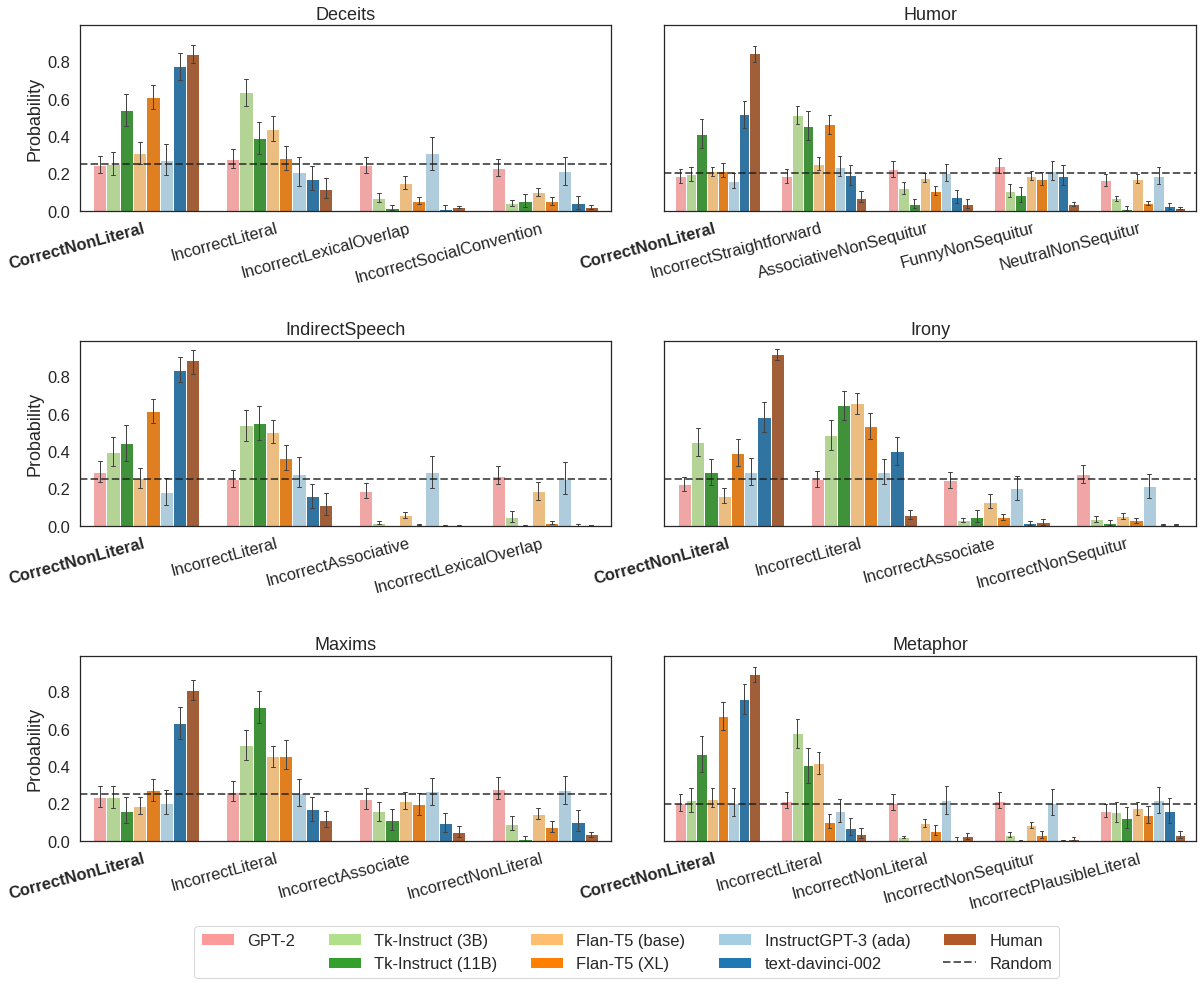

In [15]:
PHEN_ORDER_NO_CI = [phen for phen in sorted(main_df.phenomenon.unique()) if phen != "Coherence"]
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=False)
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        phen_idx = np.ravel_multi_index([i,j], (nrows, ncols))
        phen = PHEN_ORDER_NO_CI[phen_idx]
        
        # Custom order of answer options: requires some manual finagling (sorry)
        data = answer_dists[answer_dists.phenomenon==phen].copy()
        if phen == "Deceits":
            # Make some labels shorter for prettier plots
            data.answer_label_complex.replace(
                {"IncorrectNonLiteralLexicalOverlap": "IncorrectLexicalOverlap",
                 "IncorrectNonLiteralSocialConvention": "IncorrectSocialConvention"},
                inplace=True
            )
        answer_options = data.answer_label_complex.unique()
        
        sorted_answer_options = ["CorrectNonLiteral"]
        if phen == "Humor":
            sorted_answer_options.append("IncorrectStraightforward")
        else:
            sorted_answer_options.append("IncorrectLiteral")
        for a in sorted(answer_options):
            if a not in sorted_answer_options:
                sorted_answer_options.append(a)
                
        # Plot!
        ax = sns.barplot(
            ax=ax,
            data=data,
            x="answer_label_complex", 
            y="prob", 
            hue="model",
            order=sorted_answer_options,
            palette=PAL, 
            hue_order=MODEL_ORDER, 
            **ERR_STYLE
        )
        
        # Title
        ax.set_title(phen)
        
        # Random baseline
        ax.axhline(CHANCE[phen], **CHANCE_STYLE)
        
        # Legend
        if i == 2 and j == 0:
            # Custom model order to get rows/columns as desired
            model_order_for_legend = ["GPT-2", "", "Tk-Instruct (3B)", "Tk-Instruct (11B)", "Flan-T5 (base)", "Flan-T5 (XL)", "InstructGPT-3 (ada)", "text-davinci-002", "Human", "Random"]
            
            legend_elements = []
            for label in model_order_for_legend:
                if label == "":
                    legend_elements.append(mlines.Line2D([], [], label="", color="white"))
                elif label == "Random":
                    legend_elements.append(mlines.Line2D([], [], label="Random", **CHANCE_STYLE))
                else:
                    legend_elements.append(Patch(facecolor=PAL[label], label=label))
            ax.legend(handles=legend_elements, title="", loc='center left', ncol=5, bbox_to_anchor=(0.2, -0.6))
        else:
            ax.get_legend().remove()
            
        # Axis labels
        if j == 0:
            ax.set_ylabel("Probability")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        
        # Tick labels
        xticklabels = ax.get_xticklabels()
        ax.set_xticklabels(xticklabels, rotation=15, ha="right") #, size="small")
        # Make Correct label bold
        labels = ax.get_xticklabels()
        for label in labels:
            if label.get_text() == "CorrectNonLiteral":
                label.set_fontweight(1000)
            
plt.subplots_adjust(wspace=0.1, hspace=0.7)
fig.set_size_inches(20,15)

render(f"answer_dists.pdf")

# By-item relationship with humans

Rendered figure to by-item_corr_heatmap.pdf


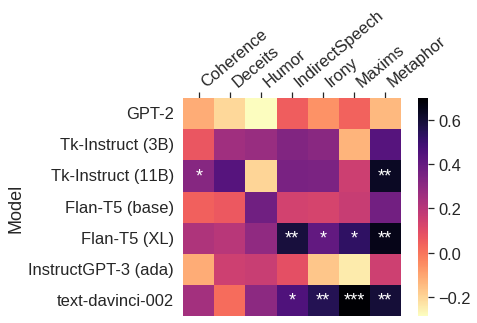

In [16]:
human_metric = "correct"
model_metric = "prob_true_answer"

def sigcode(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""
    
h = main_df[main_df.model=="Human"].groupby(["phenomenon", "item_id"])[human_metric].mean().to_frame().reset_index()
    
phens = sorted(main_df.phenomenon.unique())
models = ARTIFICIAL_MODELS #["Tk-Instruct (11B)", "Flan-T5 (XL)", "text-davinci-002"]
A_r = np.zeros((len(phens), len(models)))
A_p = np.zeros((len(phens), len(models)))
A_sig = np.zeros((len(phens), len(models))).tolist()

for i, phen in enumerate(phens):
    for j, model in enumerate(models):
        m = main_df[main_df.model==model].groupby(["phenomenon", "item_id"])[model_metric].mean().to_frame().reset_index()
    
        h_items = h[h.phenomenon==phen].item_id.unique()
        m_items = m[m.phenomenon==phen].item_id.unique()
        items = set(h_items).intersection(set(m_items))
        xs = [m[(m.phenomenon==phen)&(m.item_id==item)].squeeze()[model_metric] for item in items]
        ys = [h[(h.phenomenon==phen)&(h.item_id==item)].squeeze()[human_metric] for item in items]

        r, p = pearsonr(xs, ys)
        A_r[i][j] = r
        A_p[i][j] = p
        A_sig[i][j] = sigcode(p)
        
ax = sns.heatmap(A_r.T, square=True, annot=np.array(A_sig).T, fmt="", cmap="magma_r")
ax.set_yticklabels(models, rotation=0)
ax.set_xticklabels(phens, rotation=40, ha="left")
ax.xaxis.tick_top() # x axis on top
ax.set_ylabel("Model")
render("by-item_corr_heatmap.pdf")

# No story

## Helper functions

In [17]:
def remove_no_change(model_dfs, suffix, model="text-davinci-002", contrast_name="has_story"):
    # How often does the control modification actually change the content?
    normal = model_dfs["main"]
    control = model_dfs[suffix]
    control = control[control.model==model]
    normal = normal[(normal.model==model)&(normal.phenomenon.isin(control.phenomenon.unique()))]
    normal = normal.set_index(["seed", "phenomenon", "item_id"])
    control = control.set_index(["seed", "phenomenon", "item_id"])
    print(len(normal.index), len(control.index))
    to_exclude = []
    for (seed, phenomenon, item_id), row in normal.iterrows():
        try:
            orig = row.content
            new = control.loc[seed, phenomenon, item_id].content
            if orig == new:
                to_exclude.append((seed, phenomenon, item_id))
        except:
            continue

    normal = normal.drop(to_exclude)
    control = control.drop(to_exclude)
    print(len(normal.index), len(control.index))
    normal[contrast_name] = True
    control[contrast_name] = False
    tmp_df = pd.concat([normal.reset_index(), control.reset_index()])
    return tmp_df

def plot_contrast_multimodel(df, contrast_name, contrast_labels, palette=None, **bar_kwargs):
    PHEN_ORDER = sorted(df[~df[contrast_name]].phenomenon.unique())
    models = df.model.unique()
    fig, axes = plt.subplots(nrows=len(models), ncols=1, sharey=True, sharex=True)
    for i, model in enumerate(models):
        ax = axes[i]
        ax = sns.barplot(
            ax=ax, data=df[(df.model==model)], 
            x="phenomenon", y="correct", 
            order=PHEN_ORDER,
            hue=contrast_name,
            hue_order=[True, False],
            palette=[PAL[model], "white"],
            **ERR_STYLE
        )
        ax.set_xlabel("")
        ax.set_ylabel("Proportion correct")
        ax2 = ax.twinx()
        ax2.yaxis.set_label_position("right")
        ax2.set_yticks([])
        ax2.set_ylabel(model, rotation=270, labelpad=22)
        
        if i == 1:
            legend_elements = [
                Patch(facecolor="k", label=contrast_labels[0]),
                Patch(facecolor="white", ec="k", lw=4, hatch="//", label=contrast_labels[1]),
            ]
            ax.legend(
                handles=legend_elements, 
                loc='center', 
                bbox_to_anchor=(0.5, -0.4), 
                ncol=2
            )
        else:
            ax.get_legend().remove()
            
        for bar_idx, bar in enumerate(ax.patches):
            if bar_idx >= len(PHEN_ORDER):
                # Have to manually specify de-saturated color to match Seaborn...
                if model == "Flan-T5 (XL)":
                    bar.set_edgecolor("#DF7F20")
                else:
                    bar.set_edgecolor("#3274A1")
                bar.set_linewidth(4)
                bar.set_hatch('/')
                
        n_phen = len(PHEN_ORDER)
        for j, phen in enumerate(PHEN_ORDER):
            # Draw different random baseline for each task
            ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*j + 0.01, xmax=(1/n_phen)*(j+1) - 0.01, **CHANCE_STYLE)
        
    fig.set_size_inches(9,6)

In [18]:
# Human data
def reformat_human_nostory(df):
    cols = [c for c in list(df) if "_" in c]
    new_data = []
    for i, row in df.iterrows():
        for col in cols:
            item_id, phenomenon = col.split("_")
            new_data.append(dict(
                ppt=row.ppt,
                item_id=int(item_id),
                phenomenon=phenomenon,
                answer=row[col]
            ))
    return pd.DataFrame(new_data)

def read_human_nostory_answercodes():
    codes = pd.read_csv("../human_data/no_story/codes/deceitsindirectironymaxims_complex.csv")
    codes.Question = codes.Question.apply(lambda s: s[1:] if s.startswith("X") else s)
    cols = [c for c in list(codes) if "${lm://Field" in c]
    new_data_nometaphor = []
    for i, row in codes.iterrows():
        item_id, phenomenon = row.Question.split("_")
        for col in cols:
            new_data_nometaphor.append(dict(
                item_id=int(item_id),
                phenomenon=phenomenon,
                answer=col,
                answer_label_complex=row[col]
            ))
    codes = pd.read_csv("../human_data/no_story/codes/metaphor_complex.csv")
    codes.Question = codes.Question.apply(lambda s: s[1:] if s.startswith("X") else s)
    cols = [c for c in list(codes) if "${lm://Field" in c]
    new_data_metaphor = []
    for i, row in codes.iterrows():
        item_id, phenomenon = row.Question.split("_")
        for col in cols:
            new_data_metaphor.append(dict(
                item_id=int(item_id),
                phenomenon=phenomenon,
                answer=col,
                answer_label_complex=row[col]
            ))
    return pd.DataFrame(new_data_nometaphor + new_data_metaphor)
    
codes = read_human_nostory_answercodes().set_index(["phenomenon", "item_id", "answer"])
human_nostory = pd.read_csv("../human_data/no_story/human_data_30ppts.csv")
human_nostory = reformat_human_nostory(human_nostory)
human_nostory["answer_label_complex"] = human_nostory.apply(
    lambda row: codes.loc[row.phenomenon, row.item_id, row.answer].answer_label_complex,
    axis=1
)
human_nostory["correct"] = human_nostory.answer_label_complex.str.startswith("Correct")
human_nostory["model"] = "Human"
human_nostory["has_story"] = False
human_nostory["phenomenon"] = human_nostory.phenomenon.replace({"PoliteDeceits": "Deceits"})
human_nostory

,ppt,item_id,phenomenon,answer,answer_label_complex,correct,model,has_story
0,1,1,Deceits,${lm://Field/3},IncorrectNonLiteralLexicalOverlap,False,Human,False
1,1,2,Deceits,${lm://Field/4},CorrectNonLiteral,True,Human,False
2,1,3,Deceits,${lm://Field/5},CorrectNonLiteral,True,Human,False
3,1,4,Deceits,${lm://Field/3},CorrectNonLiteral,True,Human,False
4,1,5,Deceits,${lm://Field/4},CorrectNonLiteral,True,Human,False
...,...,...,...,...,...,...,...,...
3145,30,16,Metaphor,${lm://Field/3},CorrectNonLiteral,True,Human,False
3146,30,17,Metaphor,${lm://Field/6},IncorrectLiteral,False,Human,False
3147,30,18,Metaphor,${lm://Field/4},IncorrectPlausibleLiteral,False,Human,False
3148,30,19,Metaphor,${lm://Field/3},CorrectNonLiteral,True,Human,False


In [19]:
# Get human accuracy deltas.
metric = "correct"
g = human_df[human_df.phenomenon.isin(human_nostory.phenomenon.unique())].groupby(
    ["model", "phenomenon", "item_id"]
)[metric].mean().to_frame().reset_index()
with_story = g.set_index(["model", "phenomenon", "item_id"])
g = human_nostory.groupby(["model", "phenomenon", "item_id"])[metric].mean().to_frame().reset_index()
no_story = g.set_index(["model", "phenomenon", "item_id"])
human_diffs = (with_story[metric] - no_story[metric]).to_frame().reset_index().rename(columns={metric: "delta"})
human_diffs

,model,phenomenon,item_id,delta
0,Human,Deceits,1,0.491444
1,Human,Deceits,2,0.403209
2,Human,Deceits,3,0.311943
3,Human,Deceits,4,0.283779
4,Human,Deceits,5,0.363815
...,...,...,...,...
100,Human,Metaphor,16,0.113191
101,Human,Metaphor,17,-0.074153
102,Human,Metaphor,18,0.159715
103,Human,Metaphor,19,0.002317


In [20]:
# Get model accuracy deltas.
models_to_include = ["Tk-Instruct (11B)", "Flan-T5 (XL)", "text-davinci-002"]
tmp_model_df = pd.concat([
    remove_no_change(model_dfs, "no-story", model=model, contrast_name="has_story")
    for model in models_to_include
])
metric = "correct"
g = tmp_model_df.groupby(["model", "phenomenon", "has_story", "item_id"])[metric].mean().to_frame().reset_index()
with_story = g[g.has_story].set_index(["model", "phenomenon", "item_id"])
no_story = g[~g.has_story].set_index(["model", "phenomenon", "item_id"])
model_diffs = (with_story[metric] - no_story[metric]).to_frame().reset_index().rename(columns={metric: "delta"})

# Combine human and model deltas.
no_story_diffs = pd.concat([human_diffs, model_diffs])

520 520
485 485
520 520
485 485
520 520
485 485


Rendered figure to no-story_delta_pointplot.pdf


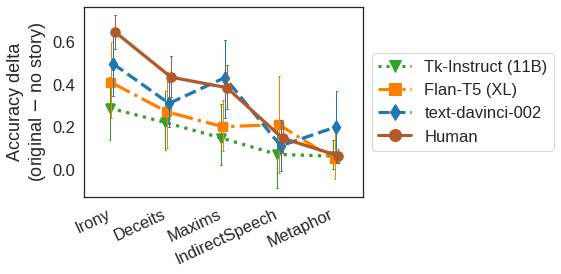

In [21]:
def plot_nostory_diffs(data, models_to_include=models_to_include+["Human"]):
    markers = ["v", "s", "d", "o"]
    linestyles = [":", "-.", "--", "-"]
    phen_order = data.groupby("phenomenon").delta.mean().sort_values(ascending=False).index
    ax = sns.pointplot(
        data=data, x="phenomenon", y="delta", order=phen_order,
        hue="model", hue_order=models_to_include, palette=PAL, dodge=True,
        markers=markers, linestyles=linestyles, scale=1.2, alpha=0.3,
        **ERR_STYLE
    )
    ax.set_xlabel("")
    ax.set_ylabel("Accuracy delta\n(original $-$ no story)")
    ax.set_xticklabels(phen_order, rotation=25, ha="right")

    # Custom legend
    legend_elements = [
        Line2D([0], [0], color=PAL[m], label=m, marker=markers[i], linestyle=linestyles[i],
                lw=3, markersize=12)
        for i, m in enumerate(models_to_include)
    ]
    ax.legend(handles=legend_elements, title="", loc='center left', bbox_to_anchor=(1, 0.5))
    xmin, xmax = ax.get_xlim()
    plt.gcf().set_size_inches(5,3.5)
    return ax
    
    
plot_nostory_diffs(no_story_diffs)
render("no-story_delta_pointplot.pdf")